In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset

In [ ]:
!mkdir training_data_64
!mkdir training_data_64/cheetah
!mkdir training_data_64/jaguar
!mkdir training_data_64/tiger

In [ ]:
!mkdir augmented_14400
!mkdir augmented_14400/cheetah
!mkdir augmented_14400/jaguar
!mkdir augmented_14400/tiger

In [ ]:
!unrar e "/content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/training_data_64/cheetah.rar" "/content/training_data_64/cheetah"
!unrar e "/content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/training_data_64/jaguar.rar" "/content/training_data_64/jaguar"
!unrar e "/content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/training_data_64/tiger.rar" "/content/training_data_64/tiger"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/training_data_64/cheetah.rar

Extracting  /content/training_data_64/cheetah/aug_0_6121912.jpg            0%  OK 
Extracting  /content/training_data_64/cheetah/aug_100_7164689.jpg          1%  OK 
Extracting  /content/training_data_64/cheetah/aug_101_2901784.jpg          1%  OK 
Extracting  /content/training_data_64/cheetah/aug_102_9506627.jpg          2%  OK 
Extracting  /content/training_data_64/cheetah/aug_103_3202380.jpg          2%  OK 
Extracting  /content/training_data_64/cheetah/aug_104_9121367.jpg          3%  OK 
Extracting  /content/training_data_64/cheetah/aug_105_6957174.jpg          3%  OK 
Extracting  /content/training_data_64/cheetah/aug_106_9084765.jpg          4%  OK 
Extracting  /content/training_data_64/cheetah/aug_107_6815822.jpg        

In [ ]:
!unrar e "/content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/augmented_14400/cheetah.rar" "/content/augmented_14400/cheetah"
!unrar e "/content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/augmented_14400/jaguar.rar" "/content/augmented_14400/jaguar"
!unrar e "/content/drive/MyDrive/2020 2021 2 _ Fernanda Januar Pratama/Coding/Dataset/augmented_14400/tiger.rar" "/content/augmented_14400/tiger"

Streaming output truncated to the last 5000 lines.
Extracting  /content/augmented_14400/jaguar/aug_392_1116542.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_1122204.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_202489.jpg            96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_2211650.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_2392956.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_269922.jpg            96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_2710708.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_358589.jpg            96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_4495676.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_4834767.jpg           96%  OK 
Extracting  /content/augmente

In [ ]:
import numpy as np
import cv2 as cv
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)

### Preprocessing

In [ ]:
def create_dataset(folders):
    dataset = []
    IMG_SIZE = 64
    CATEGORIES = ['cheetah', 'jaguar', 'tiger']
    
    for category in CATEGORIES:
        class_name = CATEGORIES.index(category)
        for file in os.listdir(os.path.join(folders, category)):
            path = os.path.join(folders, category, file)
            image = cv.imread(path, 0)
            
            # CLAHE (Contrast Limited Adaptive Histogram Equalization)
            #clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2,2))
            #clahe_img = clahe.apply(image)
            
            # Median filter + Otsu
            #blur = cv.medianBlur(clahe_img, 3)
            otsu = cv.threshold(image, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
            
            image= cv.resize(otsu, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
            dataset.append([image, class_name])
            
    return dataset

dataset_ori = create_dataset('/content/training_data_64')
print('The number of original images : {}'.format(len(dataset_ori)))

dataset_aug = create_dataset('/content/augmented_14400')
print('The number of augmentation images : {}\n'.format(len(dataset_aug)))

# combine dataset with dataset augmentation
image_data = []
label_data = []
for image, label in dataset_ori:
    image_data.append(image)
    label_data.append(label)

for image, label in dataset_aug:
    image_data.append(image)
    label_data.append(label)
    
image_data = np.array(image_data)
#image_array = np.expand_dims(image_array, -1)    # (300, 180, 180) -> (300, 180, 180, 1)
label_data = np.array(label_data)

print('\nType : {}'.format(type(image_data)))
print('The number of the entire image : {}'.format(len(image_data)))
print('The number of the class image : {}'.format(len(label_data)))

The number of original images : 600
The number of augmentation images : 14400


Type : <class 'numpy.ndarray'>
The number of the entire image : 15000
The number of the class image : 15000


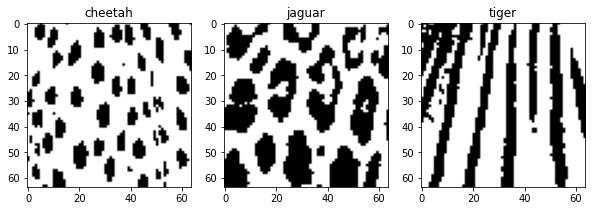

In [ ]:
# Plotting
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(image_data[0], cmap='gray'), ax[0].set_title('cheetah')
ax[1].imshow(image_data[200], cmap='gray'), ax[1].set_title('jaguar')
ax[2].imshow(image_data[400], cmap='gray'), ax[2].set_title('tiger')

plt.show()

### Feature Descriptor

In [ ]:
# feature descriptor using hog

def hog_feature_descriptor(images): 
    hog_img = []
    vis_img = []
    for sample in range(image_data.shape[0]):
        fd, img = hog(images[sample], orientations=9,
                      pixels_per_cell=(8,8), cells_per_block=(2,2), 
                      visualize = True, 
                      multichannel = False, 
                      feature_vector = True)

        hog_img.append(fd)
        vis_img.append(img)

        hog_array = np.array(hog_img)
        vis_array = np.array(vis_img)
        
    return hog_array, vis_array

start = time.perf_counter()
hog_vector, hog_img = hog_feature_descriptor(image_data)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

print("Shape :", hog_vector.shape)
print("Size : ", hog_vector.size)

Elapsed 1699.265 seconds.
Shape : (15000, 1764)
Size :  26460000


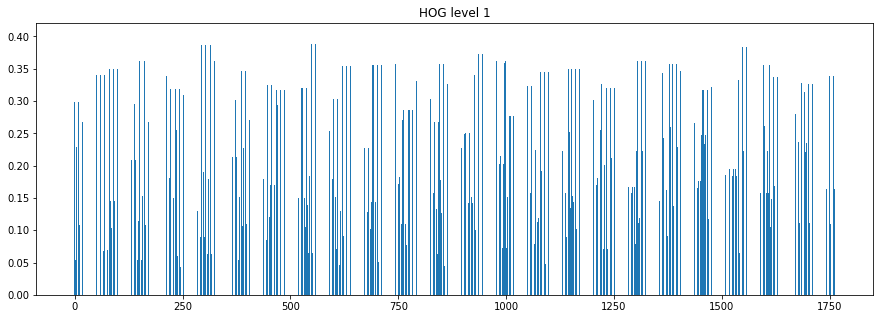

In [ ]:
vals = range(len(hog_vector[1]))
plt.figure(figsize=(15,5))

plt.bar(vals, hog_vector[1]); 
plt.title('HOG level 1')
plt.show()

### Classification

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


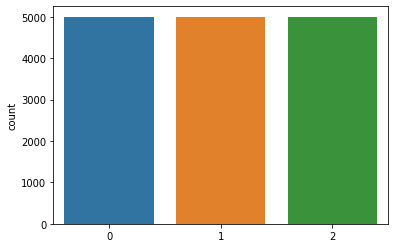

In [ ]:
# Check what is the dataset balance or not?
import seaborn as sns
sns.countplot(label_data)
#plt.xticks(rotation=90)
plt.show()

In [ ]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(hog_vector, label_data, 
                                                    shuffle=True,
                                                    stratify=label_data,
                                                    random_state=0,
                                                    test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(12000, 1764)
(3000, 1764)


In [ ]:
start = time.perf_counter()
# Validation
pipe = SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma=0.1)
cv = StratifiedKFold(n_splits=10)
validation = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Training
pipe = SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma=0.1, probability=True)
pipe.fit(x_train, y_train)
y_pred_train = pipe.predict(x_train)
y_pred_test = pipe.predict(x_test)    # Testing

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

# ROC_AUC
pred_prob_test = pipe.predict_proba(x_test)
roc_auc_test = roc_auc_score(y_test, pred_prob_test, multi_class='ovo')

Elapsed 2646.678 seconds.


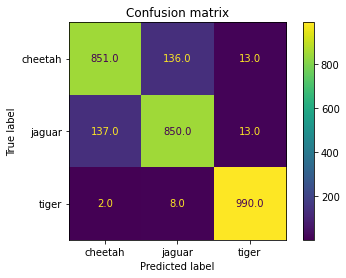

In [ ]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(pipe, x_test, y_test,
                             display_labels=['cheetah', 'jaguar', 'tiger'], 
                             values_format='.1f')

disp.ax_.set_title("Confusion matrix")
plt.show()

In [ ]:
print('Accuracy_Val : {:.4f}\n'.format(validation.mean()))

print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
from sklearn.metrics import classification_report
target_names = ['cheetah', 'jaguar', 'tiger']
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test, 
                                                                  target_names=target_names))

print("\nAUC-ROC_test : {:.4f}".format(roc_auc_test))
print('Elapsed %.3f seconds.' % elapsed)

Accuracy_Val : 0.8894

Accuracy_test : 0.8970 Precision_test : 0.8964 Recall_test : 0.8970 F1-Score : 0.8967

classification report testing : 
               precision    recall  f1-score   support

     cheetah       0.86      0.85      0.86      1000
      jaguar       0.86      0.85      0.85      1000
       tiger       0.97      0.99      0.98      1000

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000


AUC-ROC_test : 0.9746
Elapsed 2646.678 seconds.


In [ ]:
#BEFORE

Accuracy_Val : 0.9012

Accuracy_test : 0.9083 Precision_test : 0.9069 Recall_test : 0.9076 F1-Score : 0.9071

classification report testing : 
               precision    recall  f1-score   support

     cheetah       0.85      0.87      0.86       948
      jaguar       0.88      0.85      0.87      1031
       tiger       0.99      1.00      0.99      1021

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000


AUC-ROC_test : 0.9799
Elapsed 3320.027 seconds.


In [ ]:
### Calculate performance testing manually
def performances_testing(y_test, y_pred):
    # True Positive
    TP_cheetah = np.sum((y_pred==0) & (y_test==0))
    TP_jaguar = np.sum((y_pred==1) & (y_test==1))
    TP_tiger = np.sum((y_pred==2) & (y_test==2))

    # False Positive
    FP_cheetah = np.sum(((y_pred==0) & (y_test==1))) + np.sum(((y_pred==0) & (y_test==2)))
    FP_jaguar = np.sum(((y_pred==1) & (y_test==0))) + np.sum(((y_pred==1) & (y_test==2)))
    FP_tiger = np.sum(((y_pred==2) & (y_test==0))) + np.sum(((y_pred==2) & (y_test==1)))

    # False Negative
    FN_cheetah = np.sum(((y_pred==1) & (y_test==0))) + np.sum(((y_pred==2) & (y_test==0)))
    FN_jaguar = np.sum(((y_pred==0) & (y_test==1))) + np.sum(((y_pred==2) & (y_test==1)))
    FN_tiger = np.sum(((y_pred==0) & (y_test==2))) + np.sum(((y_pred==1) & (y_test==2)))

    # True Negative
    TN_cheetah = y_test.shape[0] - (TP_cheetah+FP_cheetah+FN_cheetah)
    TN_jaguar = y_test.shape[0] - (TP_jaguar+FP_jaguar+FN_jaguar)
    TN_tiger = y_test.shape[0] - (TP_tiger+FP_tiger+FN_tiger)

    #---------------------------------------------------------------------------#

    ## Precision (MACRO)
    precision_cheetah = TP_cheetah / (TP_cheetah + FP_cheetah)
    precision_jaguar = TP_jaguar / (TP_jaguar + FP_jaguar)
    precision_tiger = TP_tiger / (TP_tiger + FP_tiger)
    precision = (precision_cheetah + precision_jaguar + precision_tiger) / 3

    ## Sensitivity/Recall/TPR (MACRO)
    recall_cheetah = TP_cheetah / (TP_cheetah + FN_cheetah)
    recall_jaguar = TP_jaguar / (TP_jaguar + FN_jaguar)
    recall_tiger = TP_tiger / (TP_tiger + FN_tiger)
    recall = (recall_cheetah + recall_jaguar + recall_tiger) / 3

    ## Specificity/TNR (MACRO)
    TNR_cheetah = TN_cheetah / (TN_cheetah + FP_cheetah)
    TNR_jaguar = TN_jaguar / (TN_jaguar + FP_jaguar)
    TNR_tiger = TN_tiger / (TN_tiger + FP_tiger)
    TNR = (TNR_cheetah + TNR_jaguar + TNR_tiger) / 3

    ## F1-Score (MACRO)
    F1 = 2 * ((precision * recall) / (precision + recall))

    # Negative Predictive Value (NPV)
    npv_cheetah = TN_cheetah / (TN_cheetah + FN_cheetah)
    npv_jaguar = TN_jaguar / (TN_jaguar + FN_jaguar)
    npv_tiger = TN_tiger / (TN_tiger + FN_tiger)
    npv = (npv_cheetah + npv_jaguar + npv_tiger) / 3
    
    return precision, recall, TNR, F1, npv

precision, recall, TNR, F1, npv = performances_testing(y_test, y_pred_test)
print("Precision: {:.4f}".format(precision))
print("Sensitivity (Recall): {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(F1))
print("Specificity: {:.4f}".format(TNR))
print("Negative Predictive Value: {:.4f}".format(npv))

Precision: 0.8964
Sensitivity (Recall): 0.8970
F1-Score: 0.8967
Specificity: 0.9485
Negative Predictive Value: 0.9487


### Predict random image